In [1]:
import numpy as np
import pandas as pd
import pickle
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from soyclustering import SphericalKMeans
from collections import Counter
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

---

# 1. Data load and preprocessing

In [2]:
data = pd.read_csv('../data/2019-2020.csv')
data.head()

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,Affiliations,Authors with affiliations,Abstract,Author Keywords,Index Keywords,Document Type,Publication Stage,Open Access,Source,EID
0,"Choi D.Y., Oh J.H., Kim J.K., Lee S.E.",57221531822;57193057094;57193067620;55857982000;,Energy efficient and low-cost server architect...,2020,KSII Transactions on Internet and Information ...,14,12,NaN,4648,4663,...,"Department of Electronic Engineering, Seoul Na...","Choi, D.Y., Department of Electronic Engineeri...",This paper proposes the Lempel-Ziv 4(LZ4) comp...,Data Compression; Hadoop Storage; Hardware Acc...,Acceleration; Costs; Digital storage; Energy e...,Article,Final,NaN,Scopus,2-s2.0-85099378902
1,"Ji J., Chung Y., Kwon Y.",57195592309;56984923500;7403457084;,The effects of cobalt phthalocyanine and polya...,2020,Journal of Power Sources,480,NaN,228860,NaN,NaN,...,"Graduate School of Energy and Environment, Seo...","Ji, J., Graduate School of Energy and Environm...",A catalyst capable of high performance and goo...,Cobalt phthalocyanine; H2O2 fuel cell; Hydroge...,Cobalt; Fuel cells; Graphene; Hydrogen peroxid...,Article,Final,NaN,Scopus,2-s2.0-85090334414
2,"Nguyen X.T., Nguyen T.N., Lee H.-J., Kim H.",57197875076;57210219943;8161276300;34770344200;,An accurate weight binarization scheme for CNN...,2020,IEIE Transactions on Smart Processing and Comp...,9,6,NaN,497,503,...,Department of Electrical and Computer Engineer...,"Nguyen, X.T., Department of Electrical and Com...","Recently, convolutional neural network (CNN)-b...",Binarization; Binary weight; Object detector; ...,NaN,Article,Final,NaN,Scopus,2-s2.0-85105278542
3,"Nov L., Chung J.-Y.",57222570971;56681595800;,Dielectric property characterisation of thin f...,2020,"IET Science, Measurement and Technology",14,10,NaN,992,996,...,"Department of Integrated IT Engineering, Seoul...","Nov, L., Department of Integrated IT Engineeri...",A new research on characterising the dielectri...,NaN,Coplanar waveguides; Dielectric properties of ...,Article,Final,NaN,Scopus,2-s2.0-85103300884
4,"Karunakaran G., Cho E.-B., Kumar G.S., Kolesni...",55480032500;7202649980;55430366400;57057275500...,Mesoporous Mg-doped hydroxyapatite nanorods pr...,2020,Ceramics International,46,18,NaN,28514,28527,...,"Biosensor Research Institute, Department of Fi...","Karunakaran, G., Biosensor Research Institute,...",The most important problem in post orthopedic ...,A; B; D. Apatite; E. Biomedical applications; ...,Crystal structure; Hydroxyapatite; Morphology;...,Article,Final,NaN,Scopus,2-s2.0-85089980054


In [3]:
with open('../data/embedding_vector.pickle', 'rb') as rf :
    vector = pickle.load(rf)

In [4]:
def text_preprocessing(data) :   
    with open('../stopwords/scientificstopwords.txt', 'r') as f :
        scientific_stopwords = f.readlines()
        scientific_stopwords = [word.strip() for word in scientific_stopwords]

    tokenized_english = []
    processed_data = []
    lemma = WordNetLemmatizer()
    final_stopwords = scientific_stopwords + stopwords.words('english')

    for _, corpus in enumerate(data) :
        tokenized_english.append(nltk.regexp_tokenize(corpus.lower(), '[A-Za-z]+'))

    for cor in tokenized_english :
        meaning_words = []
        for word in cor :
            if len(word) > 1 :
                if word not in final_stopwords :
                    meaning_words.append(lemma.lemmatize(word))
            
        processed_data.append(meaning_words)

    return processed_data

In [5]:
processed_data = text_preprocessing(data.Abstract)

In [6]:
tsne_vector = TSNE(n_components=2).fit_transform(vector)

---

# 2. Conduct clustering

## 2-1. KMeans clustering (Embedding size : 15)
- scikit-learn에서 제공하는 클러스터링 알고리즘을 사용하여 클러스터링 진행 
- 클러스터링 결과를 T-SNE로 시각화

In [7]:
kmeans = KMeans(n_clusters=15, random_state=1121).fit(vector)
kmeans_clusters = kmeans.labels_

### 2-1-1. TSNE 시각화 

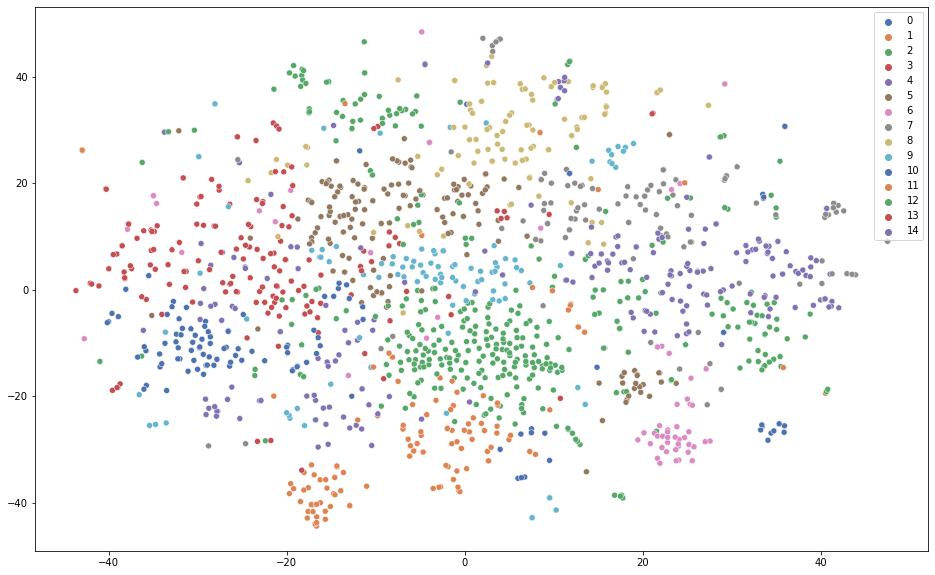

In [8]:
fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(tsne_vector[:,0], tsne_vector[:,1], hue=kmeans_clusters, palette='deep', ax=ax)
plt.show()

- 클러스터별로 유사하게 묶이긴 하나 중간중간 다른 다른 클러스터에 침범한 데이터가 다수 보임 

### 2-1-2. 네트워크 내 클러스터 비중 

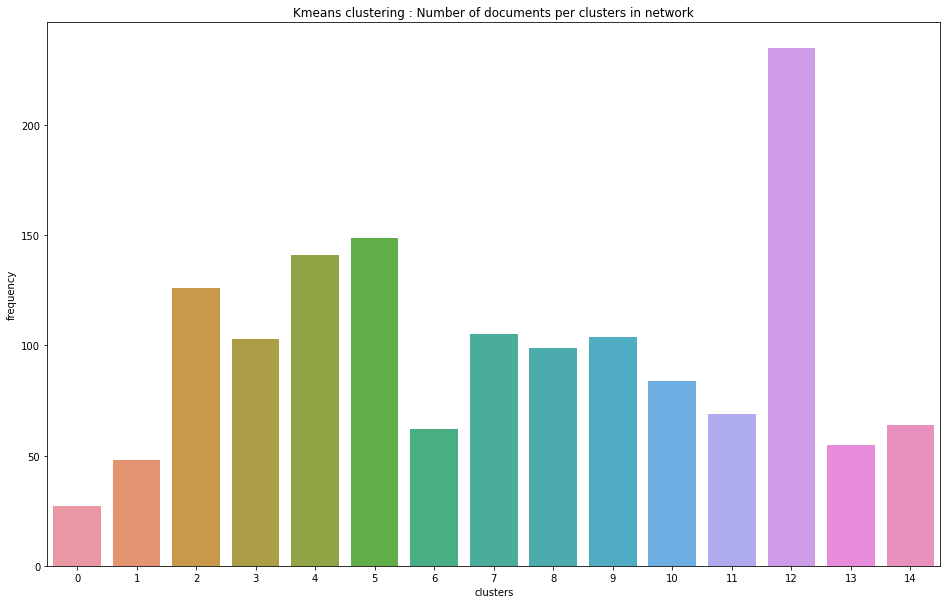

In [9]:
count_cluster = {i : kmeans_clusters.tolist().count(i) for i in range(15)}

fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x=list(count_cluster.keys()), y=list(count_cluster.values()), ax=ax)
plt.title('Kmeans clustering : Number of documents per clusters in network')
plt.xlabel('clusters')
plt.ylabel('frequency')
plt.show()

### 2-1-3. 클러스터 별 단어 분포 확인 

In [10]:
# 클러스터 별 abstract 추출 
# 클러스터 별 title 추출
abstract_per_cluster_kmeans = {idx : [] for idx in range(15)}
title_per_cluster_kmeans = {idx : [] for idx in range(15)}
for idx, clus in enumerate(kmeans_clusters) :
    abstract_per_cluster_kmeans[clus].append(processed_data[idx])
    title_per_cluster_kmeans[clus].append(data.loc[idx, 'Title'])

In [11]:
def count_word_frequency(data) :
    clusters = list(data.keys())
    abstracts = list(data.values())
    output = {idx : None for idx in clusters}

    for idx in clusters :
        corpus = abstracts[idx]
        remove_duplicate_words = []

        for word_idx in range(len(corpus)) :
            unique_words = list(set(corpus[word_idx]))
            remove_duplicate_words += unique_words 

        output[idx] = pd.DataFrame(Counter(remove_duplicate_words), index=[0]).T.sort_values(by=[0], ascending=False)
        output[idx] = output[idx].set_axis(['frequency'], axis=1)
        output[idx]['clusters'] = [idx] * len(output[idx])
        output[idx] = output[idx][output[idx]['frequency'] >= 3] 

    

    return output

In [12]:
kmeans_result = count_word_frequency(abstract_per_cluster_kmeans)

In [13]:
idx = 0
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(5) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 0 : 27
             frequency  clusters
application         13         0
property            12         0
surface             10         0
effect              10         0
also                10         0
society              9         0
hydrogel             9         0
cell                 9         0
well                 9         0
composition          8         0
membrane             8         0
drug                 7         0
nmr                  7         0
ph                   7         0
however              7         0
scanning             7         0
tissue               7         0
polymer              7         0
acid                 7         0
interaction          6         0


Study and Evaluation of the Potential of Lipid Nanocarriers for Transdermal Delivery of siRNA
Self-crosslinking hyaluronic acid-carboxymethylcellulose hydrogel enhances multilayered 3D-printed construct shape integrity and mechanical stability for soft tissue engineer

- 조직공학(화학공학)
- 전공자 문의 필요

In [14]:
idx = 1
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(5) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 1 : 48
               frequency  clusters
climate               28         1
rainfall              21         1
water                 21         1
found                 19         1
change                19         1
due                   18         1
temperature           16         1
precipitation         16         1
gcms                  15         1
author                15         1
part                  14         1
projection            14         1
observed              14         1
mean                  13         1
however               13         1
period                12         1
season                12         1
circulation           12         1
rcp                   12         1
higher                12         1


Volatility in rainfall and predictability of droughts in northwest Bangladesh
Projection of meteorological droughts in Nigeria during growing seasons under climate change scenarios
Comparison of ensembles projections of rainfa

- 건조 지역의 가뭄 예측 (기후 공학)
- 명확

In [15]:
idx = 2
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(5) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 2 : 126
                 frequency  clusters
surface                 48         2
carbon                  47         2
material                45         2
due                     40         2
acid                    39         2
effect                  38         2
chemical                38         2
also                    37         2
ion                     34         2
cell                    33         2
society                 33         2
korean                  30         2
electrochemical         29         2
however                 29         2
energy                  29         2
electron                28         2
higher                  27         2
power                   27         2
excellent               27         2
metal                   26         2


The effects of cobalt phthalocyanine and polyacrylic acid on the reactivity of hydrogen peroxide oxidation reaction and the performance of hydrogen peroxide fuel cell
Mesoporous Mg-do

- 전기화학 (화학공학)
- 산, 염기, 전기등 관련 키워드 다수
- 명확

In [16]:
idx = 3
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(10) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 3 : 103
            frequency  clusters
algorithm          43         3
ieee               31         3
however            30         3
simulation         30         3
also               29         3
order              27         3
author             25         3
experiment         21         3
well               21         3
term               20         3
due                18         3
neural             17         3
network            17         3
signal             16         3
non                16         3
value              16         3
first              16         3
deep               15         3
one                15         3
use                14         3


Comparisons of two types of particle tracking models including the effects of vertical velocity shear
Motion-aware interplay between wigig and wifi for wireless virtual reality
Efficient isoparametric trimmed-hexahedral elements with explicit shape functions
Effect of Blending Ratio and 

- 딥러닝 기술을 다양한 도메인에 응용 
- 무선 통신, 최적 설계, 유기화학 관련 내용이 혼재되어있음 
- 그러나 상호간의 기술 융합으로 보긴 힘들고 개별적으로 존재 

In [17]:
idx = 4
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(10) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 4 : 141
                 frequency  clusters
property                62         4
material                61         4
temperature             56         4
effect                  46         4
oxide                   44         4
film                    42         4
deposition              39         4
energy                  38         4
atomic                  38         4
due                     37         4
electrical              37         4
surface                 35         4
chemical                30         4
electrochemical         30         4
fabricated              30         4
society                 27         4
formation               27         4
electron                27         4
however                 26         4
interface               25         4


Hydrogenerated black titanium dioxide-embedded conducting polymer for boosting electron flow in perovskite devices
Impedance study on humidity dependent conductivity of polymer compos

- 배터리 관련 연구(화학 공학)

In [18]:
idx = 5
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(6) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 5 : 149
            frequency  clusters
simulation         59         5
power              56         5
korean             47         5
voltage            45         5
ieee               35         5
also               32         5
due                32         5
speed              31         5
effect             30         5
present            29         5
energy             29         5
right              29         5
society            29         5
reserved           29         5
author             28         5
controller         28         5
operation          27         5
condition          27         5
grid               26         5
new                25         5


Simple P-I diagram for structural components based on support rotation angle criteria
Analysis of improvement effect of rail design standard for high speed application of existing rail lines
Applicability evaluation of dynamic amplification factor considering track support stiffness
Stud

- 철도 선로 최적화 및 제어공학 (철도전문대학원, 전자공학)
- 둘 사이의 결합은 찾기 힘들고 개별적으로 존재 

In [19]:
idx = 6
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(5) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 6 : 62
             frequency  clusters
antenna             31         6
band                28         6
ghz                 23         6
db                  21         6
application         20         6
mm                  19         6
bandwidth           18         6
substrate           17         6
ieee                16         6
radiation           16         6
fabricated          16         6
effect              15         6
wave                15         6
also                14         6
dbi                 13         6
size                13         6
compact             13         6
space               13         6
material            12         6
impedance           12         6


Dielectric property characterisation of thin films based on iterative comparisons of fullwave simulations and measurements
Zno nanorods-based piezoelectric nanogenerators on double-sided conducting paper
Multilayered salt water with high optical transparency for EMI s

- 공학 전반 
- 무선통신, 재료공학, 분자공학 관련 주제가 독자적으로 존재
- 클러스터링이 제대로 진행되지 않았다고 판단 
  
- 그러나 키워드 특징으로만 보면 '전파공학'과 매우 유사

In [20]:
idx = 7
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(5) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 7 : 105
             frequency  clusters
surface             46         7
material            38         7
society             37         7
property            31         7
temperature         29         7
fabrication         27         7
polymer             26         7
also                26         7
metal               24         7
part                23         7
effect              23         7
application         22         7
pressure            22         7
fabricated          21         7
substrate           21         7
mechanical          21         7
device              20         7
cu                  20         7
korean              20         7
mold                19         7


A Feasible and Holistic Characterization of an Affordable Anti-Fog Coating Enhancing Readability
Effect of nozzle L/D of gasoline direct injection injectors on spray characteristics under different superheated degrees
Anti-oxidant copper layer by remote mode N2 plasm

- 고분자 공학 (화학 공학)

In [21]:
idx = 8
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(5) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 8 : 99
           frequency  clusters
material          44         8
strength          39         8
however           36         8
effect            32         8
specimen          30         8
steel             28         8
author            27         8
property          26         8
condition         24         8
society           23         8
due               23         8
also              23         8
crack             23         8
surface           22         8
test              22         8
strain            22         8
pipe              20         8
tensile           19         8
numerical         19         8
pressure          18         8


Floor vibration experiment and serviceability test of iFLASH system
Analysis on the effects of external temperature and welding speed on the safety of EVA waterproofing sheet joints by hot air welding
Optimal design of annular phased array transducers for material nonlinearity determination in pulse–echo ultr

- 안전 공학(안정공학과)
- 논문 제목으로 볼때 명확 

In [22]:
idx = 9
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(10) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 9 : 104
            frequency  clusters
korea              47         9
south              42         9
author             40         9
korean             36         9
also               35         9
however            34         9
value              30         9
use                27         9
cost               26         9
energy             25         9
therefore          24         9
purpose            23         9
public             23         9
first              22         9
government         22         9
market             22         9
economic           20         9
one                19         9
effect             19         9
price              18         9


Process design and economic evaluation of condensate recycling process for steam consumption reduction
Public preference toward an energy transition policy: the case of South Korea
Expand, relocate, or underground? Social acceptance of upgrading wastewater treatment plants
Public perspec

- 최적화 및 경제성 공학(산업공학)

In [23]:
idx = 10
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(10) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 10 : 84
              frequency  clusters
however              40        10
internet             34        10
security             32        10
iot                  31        10
thing                30        10
blockchain           30        10
device               28        10
environment          26        10
application          26        10
smart                25        10
architecture         24        10
service              22        10
author               20        10
new                  19        10
attack               19        10
many                 19        10
also                 18        10
solution             18        10
term                 17        10
use                  16        10


Energy efficient and low-cost server architecture for hadoop storage appliance
Autochain platform: expert automatic algorithm Blockchain technology for house rental dApp image application model
HANMRE - An authenticated encryption secure against 

- 정보보안 for 사물인터넷, 블록체인 (컴퓨터 공학)
- 근근히 이상한 논문도 섞여있지만 정보보안 관련 내용이 다수 차지 

In [24]:
idx = 11
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(10) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 11 : 69
             frequency  clusters
effect              26        11
also                21        11
cell                20        11
however             20        11
author              18        11
society             16        11
expression          16        11
mdpi                15        11
korean              15        11
gene                14        11
licensee            14        11
basel               14        11
switzerland         14        11
change              14        11
production          13        11
protein             13        11
food                12        11
observed            12        11
acid                12        11
higher              12        11


Simultaneous control of staphylococcus aureus and bacillus cereus using a hybrid endolysin lysb4ead-lyssa11
Cardiometabolic risk factor in obese and normal weight individuals in community dwelling men
Analysis of age-based bone mineral density in the korean adult pop

- 생리학 (화공생명공학과)

In [25]:
idx = 12
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(10) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 12 : 235
             frequency  clusters
society             57        12
korean              51        12
also                51        12
effect              39        12
water               39        12
limit               38        12
could               37        12
sample              32        12
author              32        12
sensor              32        12
right               31        12
chemosensor         29        12
synthesized         29        12
uv                  28        12
reserved            28        12
well                28        12
calculation         28        12
one                 28        12
esi                 27        12
mass                26        12


Compact Ultra Wide-Band and Tri-Band Antenna for Portable Device
Antioxidant compounds and activities of pedicel and sepals from twelve varieties of colored cherry tomatoes
Comparisons of the anti‐inflammatory activity of dendropanax morbifera lev leaf extract conte

- 화학 물질 검출 및 분류 (화공생명공학과)

In [26]:
idx = 13
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(10) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 13 : 55
               frequency  clusters
image                 34        13
algorithm             27        13
object                22        13
however               21        13
ieee                  19        13
new                   14        13
deep                  13        13
icros                 12        13
use                   12        13
one                   12        13
sensor                12        13
proposes              11        13
korean                11        13
camera                11        13
autonomous            11        13
map                   10        13
therefore             10        13
convolutional         10        13
space                 10        13
without               10        13


An accurate weight binarization scheme for CNN object detectors with two scaling factors
An Efficient Sampling Algorithm with a K-NN Expanding Operator for Depth Data Acquisition in a LiDAR System
Energy saving of a universit

- 객체 인식 모델 (컴퓨터 공학)
- 경량 CNN, 객체 등의 키워드 다수 

In [27]:
idx = 14
print('Number of document in cluster {} : {}'.format(idx, count_cluster[idx]))
print(kmeans_result[idx].head(20))
print('\n')
for i in range(10) :
    print(title_per_cluster_kmeans[idx][i])

Number of document in cluster 14 : 64
             frequency  clusters
also                24        14
conducted           19        14
user                18        14
however             17        14
korean              14        14
environment         13        14
service             13        14
new                 13        14
algorithm           13        14
quality             13        14
machine             12        14
first               12        14
value               12        14
therefore           12        14
many                11        14
use                 11        14
author              11        14
collected           11        14
social              10        14
physical            10        14


Identification of promising inventions considering the quality of knowledge accumulation: a machine learning approach
Athlete-specific neural strategies under pressure: A fnirs pilot study
Serendipity adjustable application recommendation via joint disentangled recur

- 설명가능한 머신러닝 (컴퓨터 공학)
- 도메인은 다양하지만 설명가능한, 머신러닝, 오토인코더 등의 키워드가 다수 포함되어있음

## 2-2. Spherical Kmeans clustering

- 보통 spherical kmeans는 벡터의 길이가 길고, sparse할 때 사용
- 그러나 doc2vec 벡터는 dense vector이며 본 연구의 임베딩 사이즈는 32이므로 이 방식보다는 일반 kmeans가 더 효과가 좋을 것으로 생각됨 

In [28]:
network = cosine_similarity(vector, vector)
network = np.where(network>0.8, 1, 0)
sparse_network = sparse.csr_matrix(network)

In [29]:
s_kmeans = SphericalKMeans(n_clusters=15, max_iter=10, random_state=1121)
s_kmeans_clusters = s_kmeans.fit_predict(sparse_network)

### 2-2-1. TSNE 시각화

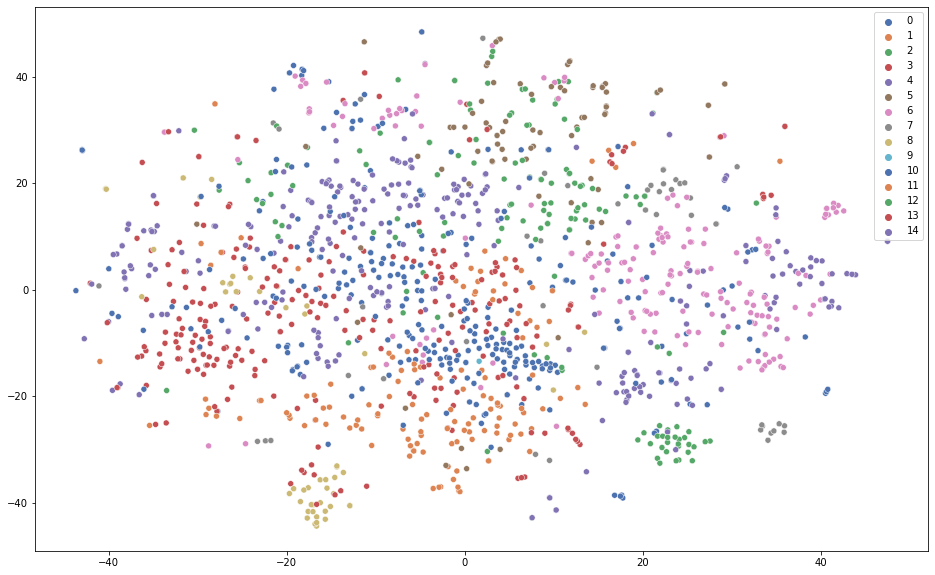

In [30]:
fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(tsne_vector[:,0], tsne_vector[:,1], hue=s_kmeans_clusters, palette='deep', ax=ax)
plt.show()

### 2-2-2. 네트워크 내 클러스터 비중

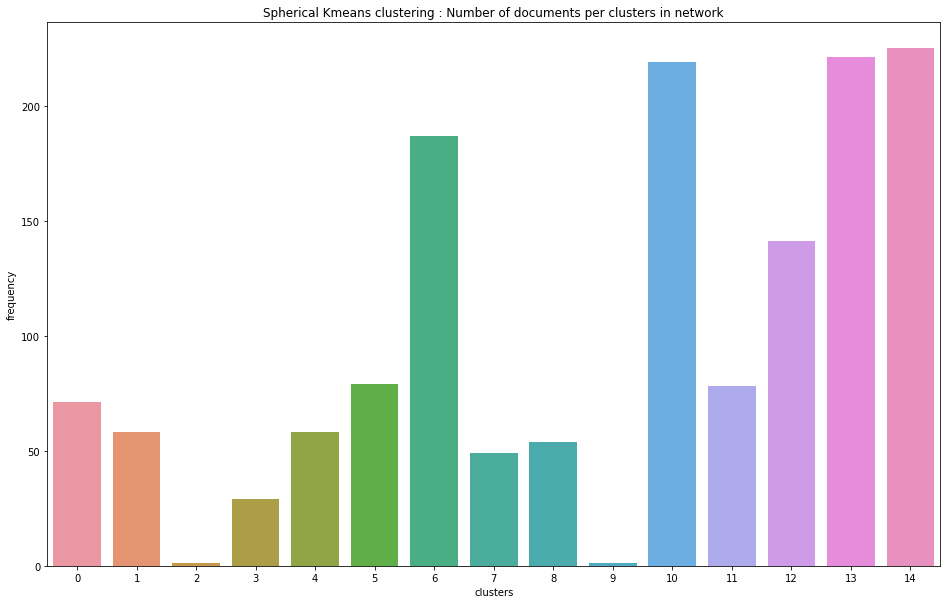

In [32]:
count_cluster = {i : s_kmeans_clusters.tolist().count(i) for i in range(15)}

fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x=list(count_cluster.keys()), y=list(count_cluster.values()), ax=ax)
plt.title('Spherical Kmeans clustering : Number of documents per clusters in network')
plt.xlabel('clusters')
plt.ylabel('frequency')
plt.show()

---

# 3. 클러스터 별 논문 추출 

In [49]:
# 'cluster', 'title' 데이터 프레임 생성
kmeans_title = pd.DataFrame(np.zeros((len(data), 2)), columns=['cluster', 'title'])

for idx, clus in enumerate(kmeans_clusters) :
    kmeans_title['cluster'][idx] = int(clus)
    kmeans_title['title'][idx] = data.loc[idx, 'Title']

In [50]:
cluster_dict = {0 : 'Tissue engineering',
                1 : 'Drought forcasting',
                2 : 'Electrochemistry', 
                3 : 'Deep learning application and simulation', 
                4 : 'Battery design', 
                5 : 'Energy control system', 
                6 : 'Radio engineering', 
                7 : 'Polymer engineering', 
                8 : 'Saftey engineering', 
                9 : 'Optimization and economic engineering', 
                10 : 'Security for IoT', 
                11 : 'Physiology', 
                12 : 'Chemical detecition and classification', 
                13 : 'Object detection', 
                14 : 'Explanable AI'}

In [51]:
# 클러스터 인덱스 -> 클러스터명으로 교체
# 클러스터 별로 정렬
kmeans_title['cluster'] = kmeans_title['cluster'].replace(cluster_dict)
kmeans_title.sort_values(by=['cluster'], inplace=True)
kmeans_title.reset_index(drop=True, inplace=True)

In [54]:
! pip install openpyxl

  Using cached openpyxl-3.0.7-py2.py3-none-any.whl (243 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [55]:
kmeans_title.to_excel('kmeans_title.xlsx')

---

# 4. Cluster 성능 평가

## 4-1. Kmeans : cluster 15개


- 엑셀로 확인한 결과, 전체 6쌍 데이터 중 3쌍 정답

## 4-2. Kmeans : cluster 30개 

In [57]:
kmeans_30 = KMeans(n_clusters=30).fit(vector)
kmeans_30_clusters = kmeans_30.labels_

In [59]:
# 'cluster', 'title' 데이터 프레임 생성
kmeans_30_title = pd.DataFrame(np.zeros((len(data), 2)), columns=['cluster', 'title'])

for idx, clus in enumerate(kmeans_30_clusters) :
    kmeans_30_title['cluster'][idx] = int(clus)
    kmeans_30_title['title'][idx] = data.loc[idx, 'Title']

In [61]:
target_paper = [1229, 143, 503, 939, 236, 700]
similar_paper = [230, 144, 195, 1046, 485, 1191]

In [69]:
correct = 0
for idx, i in enumerate(target_paper) : 
    if kmeans_30_title.loc[i, 'cluster'] == kmeans_30_title.loc[similar_paper[idx], 'cluster'] :
        correct += 1
        print('right')
    else :
        print('wrong')

print('\n')
print('Number of correct answer in kmeans with 30 : {}'.format(correct))

wrong
right
right
wrong
right
wrong


Number of correct answer in kmeans with 30 : 3


## 4-3. Spherical kmeans : cluster 15개

In [71]:
# 'cluster', 'title' 데이터 프레임 생성
s_kmeans_title = pd.DataFrame(np.zeros((len(data), 2)), columns=['cluster', 'title'])

for idx, clus in enumerate(s_kmeans_clusters) :
    s_kmeans_title['cluster'][idx] = int(clus)
    s_kmeans_title['title'][idx] = data.loc[idx, 'Title']

In [73]:
correct = 0
for idx, i in enumerate(target_paper) : 
    if s_kmeans_title.loc[i, 'cluster'] == s_kmeans_title.loc[similar_paper[idx], 'cluster'] :
        correct += 1
        print('right')
    else :
        print('wrong')

print('\n')
print('Number of correct answer in spherical kmeans with 15 : {}'.format(correct))

wrong
wrong
wrong
wrong
right
right


Number of correct answer in spherical kmeans with 15 : 2


## 4-4. Spherical kmeans : cluster 30개

In [74]:
s_kmeans_30 = SphericalKMeans(n_clusters=30, random_state=1121, max_iter=10)
s_kmeans_30_clusters = s_kmeans_30.fit_predict(sparse_network)

In [75]:
# 'cluster', 'title' 데이터 프레임 생성
s_kmeans_30_title = pd.DataFrame(np.zeros((len(data), 2)), columns=['cluster', 'title'])

for idx, clus in enumerate(s_kmeans_30_clusters) :
    s_kmeans_30_title['cluster'][idx] = int(clus)
    s_kmeans_30_title['title'][idx] = data.loc[idx, 'Title']

In [76]:
correct = 0
for idx, i in enumerate(target_paper) : 
    if s_kmeans_30_title.loc[i, 'cluster'] == s_kmeans_30_title.loc[similar_paper[idx], 'cluster'] :
        correct += 1
        print('right')
    else :
        print('wrong')

print('\n')
print('Number of correct answer in spherical kmeans with 15 : {}'.format(correct))

wrong
right
wrong
wrong
right
wrong


Number of correct answer in spherical kmeans with 15 : 2
